Notebook 3, do some additional feature exploration to see if we can find places to improve upon our previous model

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from plotnine import *
import itertools
import seaborn as sns
%matplotlib inline

df = pd.read_csv('sac_animals.csv', parse_dates=True)
df = df[df['outcome_type'].isin(['ADOPTION' ,'FOSTER', 'RTO', 'EUTH', 'TRANSFER', 'RTF', 'DIED', 'EUTH VET'])]

In [2]:
df.head()

,objectid,animal_id,animal_name,animal_type,activity_number,intake_type,picked_up_location,intake_date,outcome_type,outcome_date,...,animal_intake_status,name_unknown,has_activity_number,animal_age_in_days,outcome_group,intake_type_clean,color_clean,intake_times,n,days_spent
0,1,A230281,GABBY,DOG,NaN,STRAY,H ST & 33RD ST,2020-01-11 08:00:00+00:00,EUTH,2020-01-13 08:00:00+00:00,...,neutured,0,0,5110,dead,unowned,black,1,1,2
1,2,A385870,PRINCESS,DOG,NaN,STRAY,4315 MARTIN LUTHER KING JR BLVD,2019-01-12 08:00:00+00:00,TRANSFER,2019-01-25 08:00:00+00:00,...,neutured,0,0,3285,other,unowned,other_solid,1,1,13
2,3,A423284,SPARKY,DOG,NaN,STRAY,1255 LAMBERTON CIRCLE,2019-08-31 07:00:00+00:00,RTO,2019-08-31 07:00:00+00:00,...,neutured,0,0,2920,to_owner,unowned,other_solid,1,1,0
3,4,A442002,MICKEY,DOG,NaN,STRAY,STOCKTON BLVD & LEMON HILL AVE,2017-12-20 08:00:00+00:00,RTO,2017-12-21 08:00:00+00:00,...,neutured,0,0,2920,to_owner,unowned,other_solid,1,1,1
4,5,A443307,ZEUS,DOG,NaN,STRAY,2415 WESTERN AVE,2018-06-29 07:00:00+00:00,RTO,2018-07-01 07:00:00+00:00,...,intact,0,0,3285,to_owner,unowned,black,1,1,2


In [3]:
df.columns

Index(['objectid', 'animal_id', 'animal_name', 'animal_type',
       'activity_number', 'intake_type', 'picked_up_location', 'intake_date',
       'outcome_type', 'outcome_date', 'animal_age', 'animal_primarycolor',
       'animal_sex', 'outcome_subtype', 'animal_sex_clean',
       'animal_intake_status', 'name_unknown', 'has_activity_number',
       'animal_age_in_days', 'outcome_group', 'intake_type_clean',
       'color_clean', 'intake_times', 'n', 'days_spent'],
      dtype='object')

Days spent has some very significant outliers, 

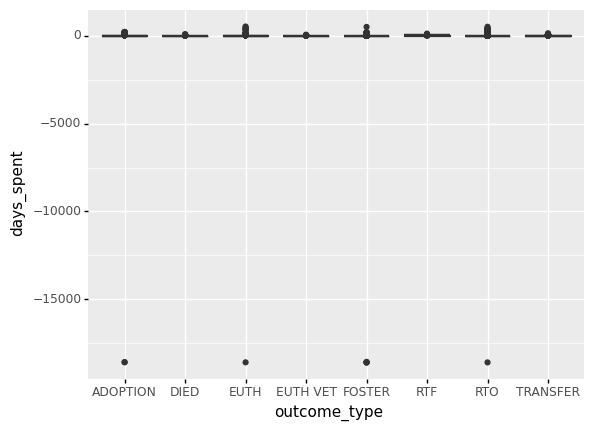

<ggplot: (331482426)>

In [4]:
(ggplot(
df, aes(x='outcome_type', y='days_spent')) + geom_boxplot()
)

/Users/justingoss/Desktop/sac_animals/sac_animals/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='days_spent', ylabel='Density'>

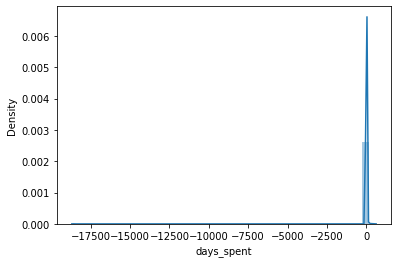

In [5]:
sns.distplot(df['days_spent'])

Some observations erroneously show up with negative time spent, we should fix this by replacing these values as 0s

In [6]:
df['intake_date'] = pd.to_datetime(df['intake_date'])
df['outcome_date'] = pd.to_datetime(df['outcome_date'])
(df['outcome_date'] < df['intake_date']).sum()

8

In [7]:
df.loc[df['days_spent'] < 0, 'days_spent'] = 0

/Users/justingoss/Desktop/sac_animals/sac_animals/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='days_spent', ylabel='Density'>

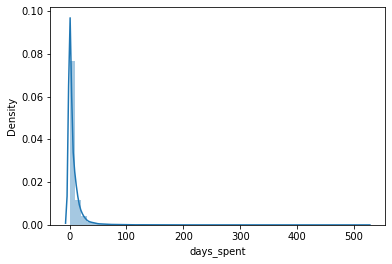

In [8]:
sns.distplot(df['days_spent'])

Animal age is also not normally distributed as we might expect it's strongly right skewed

/Users/justingoss/Desktop/sac_animals/sac_animals/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='animal_age_in_days', ylabel='Density'>

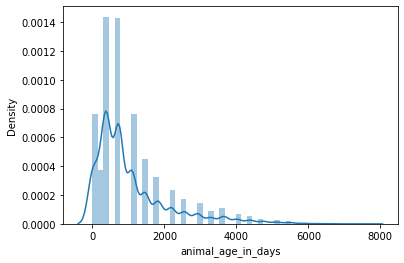

In [9]:
sns.distplot(df['animal_age_in_days'])

In [10]:
pd.crosstab(df.intake_type_clean, df.outcome_type)

outcome_type,ADOPTION,DIED,EUTH,EUTH VET,FOSTER,RTF,RTO,TRANSFER
intake_type_clean,,,,,,,,
other,53,8,112,0,47,3,58,6
owned_safe,7729,33,329,11,1918,43,166,340
owned_unsafe,215,4,152,2,238,0,700,57
unowned,5865,230,2705,145,8173,920,3903,1413


In [11]:
pd.crosstab(df.intake_type, df.outcome_type, normalize='columns')

outcome_type,ADOPTION,DIED,EUTH,EUTH VET,FOSTER,RTF,RTO,TRANSFER
intake_type,,,,,,,,
CONFISCATE,0.015510,0.014545,0.045179,0.012658,0.022648,0.000000,0.107313,0.031388
EUTH REQ,0.000289,0.010909,0.030928,0.000000,0.000096,0.000000,0.000414,0.001101
FOSTER,0.516015,0.116364,0.067617,0.069620,0.173863,0.042443,0.024860,0.154185
HOMELESS,0.000000,0.000000,0.000910,0.000000,0.000096,0.000000,0.037290,0.000000
MEDICAL,0.000216,0.014545,0.001516,0.000000,0.000482,0.003106,0.009944,0.000000
OWNER SUR,0.032030,0.058182,0.119770,0.037975,0.031322,0.016563,0.030039,0.052313
PR CUSTODY,0.000000,0.000000,0.000000,0.000000,0.000193,0.000000,0.000414,0.000000
QUARANTINE,0.000216,0.000000,0.007884,0.000000,0.000000,0.001035,0.006629,0.000000
RETURN,0.041336,0.003636,0.024257,0.000000,0.010987,0.001035,0.002900,0.033040


In [12]:
pd.set_option('display.max_rows', 500)
pd.crosstab(df.outcome_subtype, df.intake_type)

intake_type,CONFISCATE,EUTH REQ,FOSTER,HOMELESS,MEDICAL,OWNER SUR,PR CUSTODY,QUARANTINE,RETURN,STRAY,TRANSFER
outcome_subtype,,,,,,,,,,,
AT VET,0,0,1,0,0,0,0,0,1,11,0
BAM,0,0,0,0,0,0,0,0,0,2,0
BARN CAT,1,0,16,0,0,12,0,2,6,55,0
BEHAVIOR,95,18,54,0,1,259,0,7,64,805,4
BITER,9,2,4,0,0,25,0,7,7,14,0
BLACKFOOT,3,0,3,0,0,4,0,0,2,60,0
BOTTLE BAB,3,0,52,0,0,12,0,0,0,822,0
CALAVER CO,0,0,2,0,0,0,0,0,1,5,0
CHEQHUMANE,0,0,0,0,0,0,0,0,0,1,0


In [13]:
df.intake_date.dt.month.value_counts()

7     3774
8     3737
6     3517
10    3294
5     3239
9     3224
12    3017
1     2677
11    2499
4     2235
2     2224
3     2141
Name: intake_date, dtype: int64

Takeaways:
1. Create month feature for intake date
2. Normalize age and days spend features to deal with outliers
3. Try disaggregating intake type again